In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('Data/combined.csv')
new_index=df['Player']
df.index=new_index
df.rename(columns={'Weekly':'Wages'},inplace=True)
df.columns

Index(['Unnamed: 0', 'Player', 'Wages', 'Pos', 'MP', 'Starts', 'Min', '90s',
       'Gls', 'Ast', 'xG', 'xA', 'Sh', 'SoT', 'G/Sh', 'G/SoT', 'Dist', 'FK',
       'PK', 'G-xG', 'SCA90', 'GCA90', 'Cmp', 'Att', 'TotDist', 'PrgDist',
       'S.Cmp', 'S.Att', 'M.Cmp', 'M.Att', 'L.Cmp', 'L.Att', 'KP', '1/3',
       'PPA', 'CrsPA', 'Prog', 'PressPass', 'Cross', 'TchDefP', 'TchDef3',
       'TchMid3', 'TchAtt3', 'TchAttP', 'DrSucc', 'DrPast', 'ProgCrr',
       'Crr1/3', 'CPA', 'Tkl', 'TklW', 'TklDef3', 'TklMid3', 'TklAtt3',
       'Press', 'Succ', 'PrsDef3', 'PrsMid3', 'PrsAtt3', 'Blocks', 'Int',
       'Clr', 'Squad', 'Recov', 'ArDuWon%', 'PrgPassDist'],
      dtype='object')

From the exploratory data anlaysis, we concluded that only a few indicators will be used to model the wages. Other performance-related columns are dropped. The total minutes played and no of minutes played are retained. Age could also influence the wage. However, that will be incorporated leter.

In [3]:
df.drop(['Unnamed: 0', 'Player','MP', 
       'Gls', 'Ast', 'G/Sh', 'G/SoT', 'Dist', 'FK',
       'PK', 'G-xG','Cmp', 'Att', 'TotDist', 'PrgDist',
       'S.Cmp', 'S.Att', 'M.Cmp', 'M.Att', 'L.Cmp', 'L.Att',
        'CrsPA','PressPass', 'Cross', 'TchDefP', 'TchDef3',
       'TchMid3', 'TchAtt3', 'TchAttP', 'DrSucc', 'DrPast', 
       'Tkl', 'TklW', 'TklDef3', 'TklMid3', 'TklAtt3',
       'Press', 'Succ', 'PrsDef3', 'PrsMid3', 'PrsAtt3', 'Blocks', 'Int',
       'Clr', 'Recov', 'ArDuWon%', 'PrgPassDist'],axis=1,inplace=True)
df.rename(columns={'1/3':'Pto3','Crr1/3':'Crrto3'},inplace=True)
df.head()

,Wages,Pos,Starts,Min,90s,xG,xA,Sh,SoT,SCA90,GCA90,KP,Pto3,PPA,Prog,ProgCrr,Crrto3,CPA,Squad
Player,,,,,,,,,,,,,,,,,,,
Aaron Cresswell,50000,DF,21,1860,20.7,0.03,0.11,0.58,0.10,1.98,0.24,1.35,3.96,0.87,5.65,3.38,1.64,0.05,WHU
Aaron Lennon,10577,MFFW,11,983,10.9,0.06,0.03,0.64,0.18,1.74,0.37,0.37,0.55,0.28,1.01,2.57,0.83,0.92,BUR
Aaron Ramsdale,71154,GK,22,1980,22.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.91,0.00,0.00,0.00,0.00,0.00,ARS
Aaron Wan-Bissaka,90000,DF,18,1613,17.9,0.01,0.05,0.22,0.06,1.73,0.06,0.78,2.07,0.67,2.68,4.92,1.79,0.22,MUN
Abdoulaye Doucouré,75000,MF,18,1594,17.7,0.11,0.08,1.36,0.34,2.20,0.34,0.79,3.22,0.79,3.50,3.16,1.24,0.28,EVE


Defenders and goalkeeper are dropped as we base our model purely on attacking performance. Nevertheless, there are defenders who contribute heavily in the attacking phase for many teams. Players who have not clocked atleast 450 minutes on the pitch (equivalent to 5 matches) are also dropped.

In [4]:
df.drop(df.index[df['Pos']=='GK'],inplace=True)
df.drop(df.index[df['Pos']=='DF'],inplace=True)
df.drop(df.index[df['Pos']=='GK'],inplace=True)
df.drop(df.index[df['90s']<5],inplace=True)
df['Pos'].unique()

array(['MFFW', 'MF', 'FW', 'FWMF', 'MFDF', 'DFMF', 'FWDF'], dtype=object)

Wage outliers have to be dropped, unless their performace indicators aren't outliers too (Exceptional performance deserves exceptional wages). To find performance ouutliers, a crude measurement, that is the sum of the all performance indicators, is used.

In [5]:
upper_bound_wage=2.5*df['Wages'].quantile(0.75)-1.5*df['Wages'].quantile(0.25)
wage_outliers=set(df.index[df.Wages>upper_bound_wage])

df['Performance']=df.xG+df.xA+df.Sh+df.SoT+df.SCA90+df.GCA90+df.KP+df.Pto3+df.PPA+df.Prog+df.ProgCrr+df.Crrto3+df.CPA
upper_bound_perf=2.5*df['Performance'].quantile(0.75)-1.5*df['Performance'].quantile(0.25)
perf_outliers=set(df.index[df.Performance>upper_bound_perf])

sdf=df.drop(wage_outliers.difference(perf_outliers))
sdf.drop('Performance',axis=1,inplace=True)

We noticed in the earlier analysis that salary varies for different positions so this information is retained. The position feature is converted to dummy variables.

In [7]:
sdf=pd.concat([sdf,pd.get_dummies(sdf['Pos'])], axis=1)
sdf.drop('Pos',axis=1,inplace=True)
sdf.head()

,Wages,Starts,Min,90s,xG,xA,Sh,SoT,SCA90,GCA90,...,Crrto3,CPA,Squad,DFMF,FW,FWDF,FWMF,MF,MFDF,MFFW
Player,,,,,,,,,,,,,,,,,,,,,
Aaron Lennon,10577,11,983,10.9,0.06,0.03,0.64,0.18,1.74,0.37,...,0.83,0.92,BUR,0,0,0,0,0,0,1
Abdoulaye Doucouré,75000,18,1594,17.7,0.11,0.08,1.36,0.34,2.20,0.34,...,1.24,0.28,EVE,0,0,0,0,1,0,0
Adam Armstrong,47885,14,1216,13.5,0.30,0.13,3.26,1.04,1.92,0.22,...,1.26,1.19,SOU,0,1,0,0,0,0,0
Adam Forshaw,20000,14,1260,14.0,0.02,0.08,0.86,0.29,1.71,0.07,...,0.93,0.07,LEE,0,0,0,0,1,0,0
Adam Idah,5000,6,625,6.9,0.29,0.09,2.03,0.58,1.73,0.14,...,0.43,0.29,NOR,0,0,0,1,0,0,0


We do some preliminary analysis to check the qualitative dependence on starts, minutes played and performance indicators.

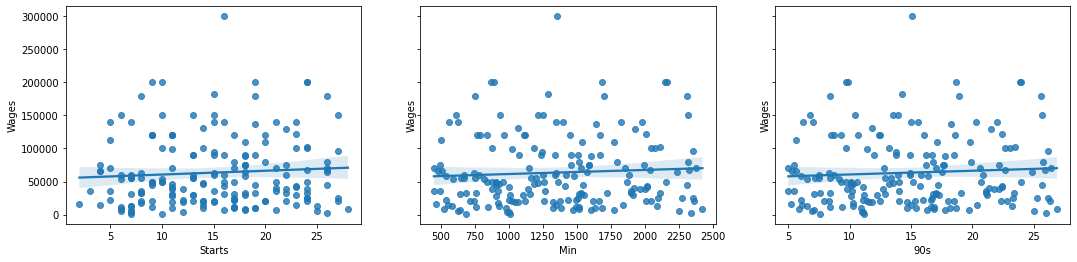

In [8]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='Starts',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='Min',y='Wages',data=sdf,ax=axes[1])
sns.regplot(x='90s',y='Wages',data=sdf,ax=axes[2])

The total minutes played (thus 90s) and starts made have no effect on the wages of the players. These parameters are dropped. 

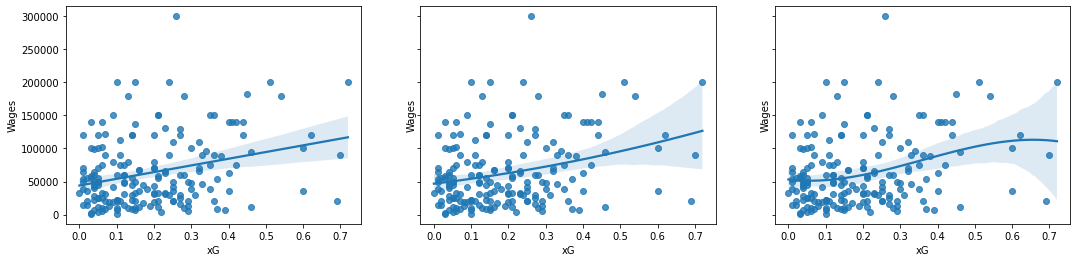

In [57]:
#sdf.drop(['Starts','Min','90s'],axis=1,inplace=True)
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='xG',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='xG',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='xG',y='Wages',data=sdf,order=3,ax=axes[2])

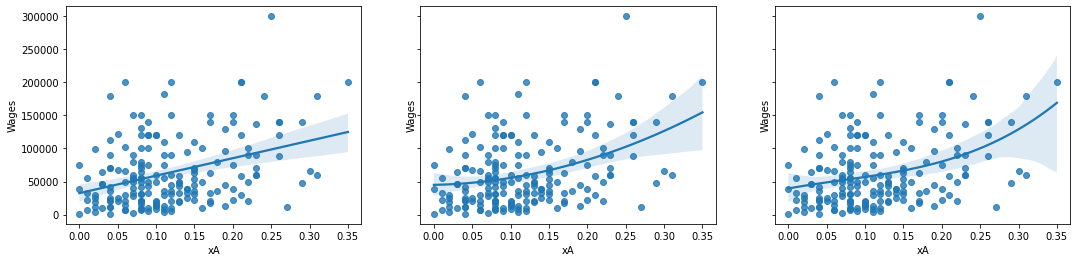

In [18]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='xA',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='xA',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='xA',y='Wages',data=sdf,order=3,ax=axes[2])

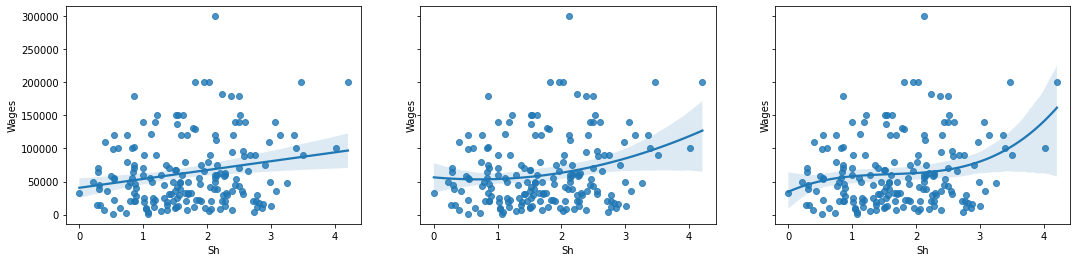

In [19]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='Sh',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='Sh',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='Sh',y='Wages',data=sdf,order=3,ax=axes[2])

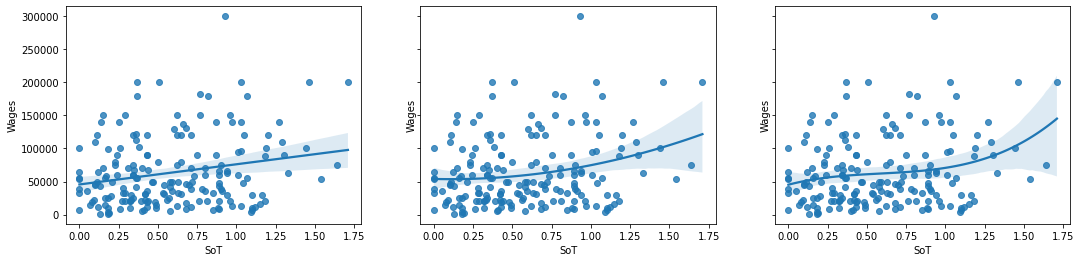

In [25]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='SoT',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='SoT',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='SoT',y='Wages',data=sdf,order=3,ax=axes[2])

(-20291.91948922938, 310000.0)

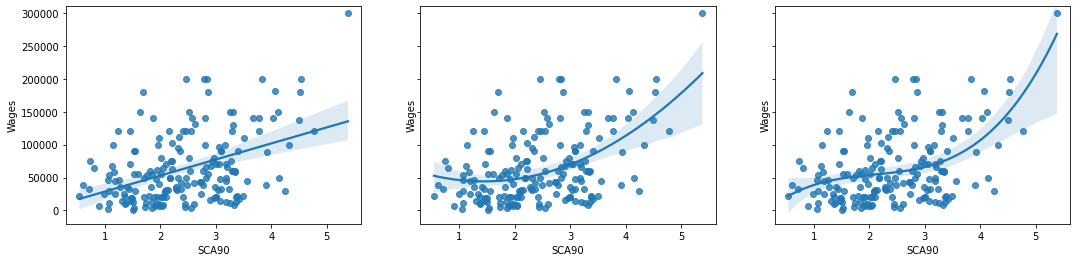

In [41]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='SCA90',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='SCA90',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='SCA90',y='Wages',data=sdf,order=3,ax=axes[2])
plt.ylim(top=310000)

(0.0, 310000.0)

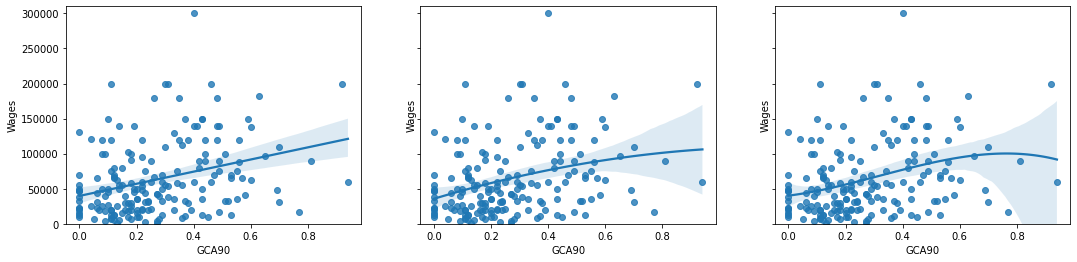

In [46]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='GCA90',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='GCA90',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='GCA90',y='Wages',data=sdf,order=3,ax=axes[2])
plt.ylim([0,310000])

(0.0, 310000.0)

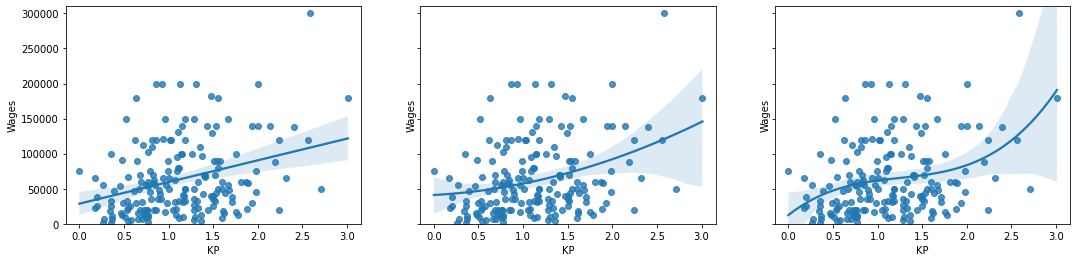

In [47]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='KP',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='KP',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='KP',y='Wages',data=sdf,order=3,ax=axes[2])
plt.ylim([0,310000])

(0.0, 310000.0)

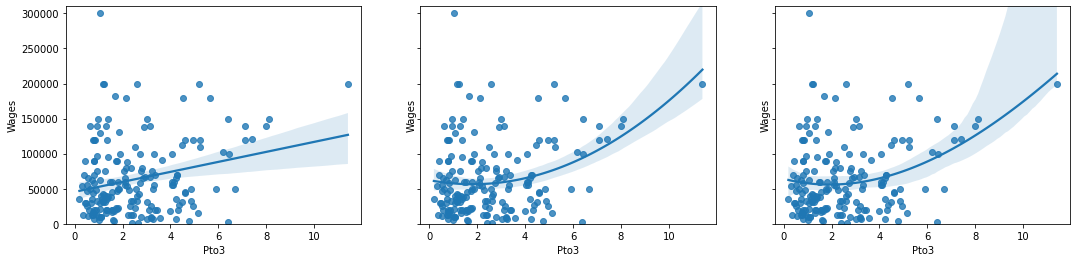

In [48]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='Pto3',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='Pto3',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='Pto3',y='Wages',data=sdf,order=3,ax=axes[2])
plt.ylim([0,310000])

(0.0, 310000.0)

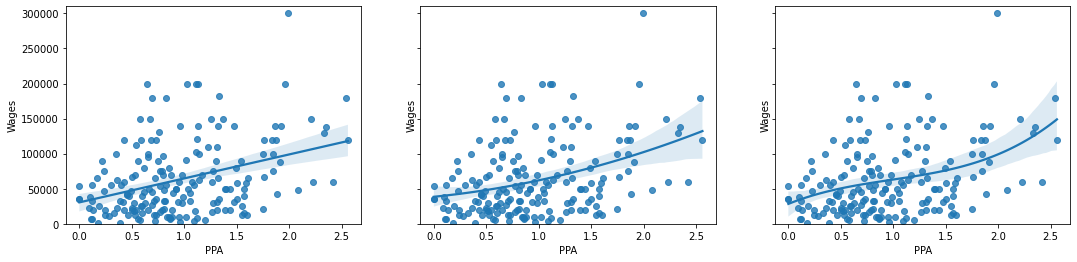

In [49]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='PPA',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='PPA',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='PPA',y='Wages',data=sdf,order=3,ax=axes[2])
plt.ylim([0,310000])

(0.0, 310000.0)

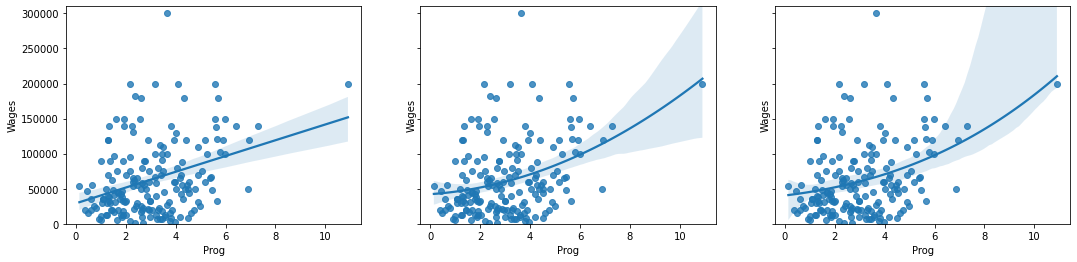

In [50]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='Prog',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='Prog',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='Prog',y='Wages',data=sdf,order=3,ax=axes[2])
plt.ylim([0,310000])

(0.0, 310000.0)

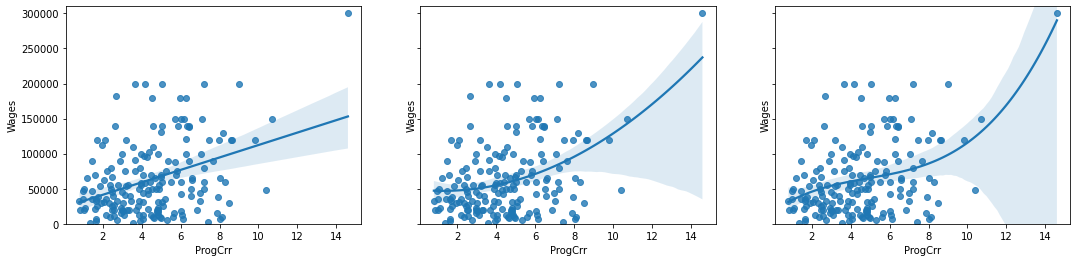

In [51]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='ProgCrr',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='ProgCrr',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='ProgCrr',y='Wages',data=sdf,order=3,ax=axes[2])
plt.ylim([0,310000])

(0.0, 310000.0)

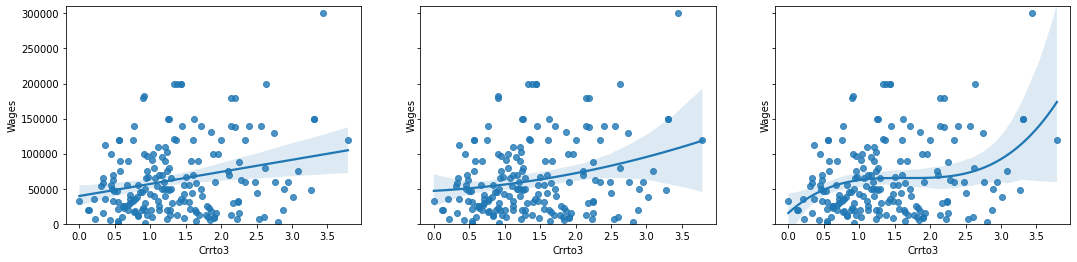

In [53]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='Crrto3',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='Crrto3',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='Crrto3',y='Wages',data=sdf,order=3,ax=axes[2])
plt.ylim([0,310000])

(0.0, 310000.0)

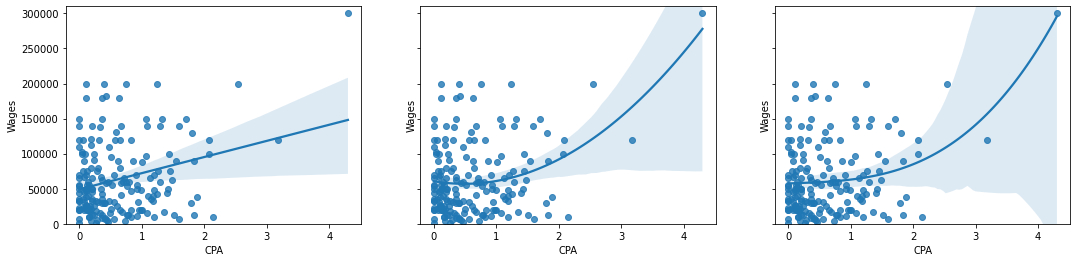

In [52]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='CPA',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='CPA',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='CPA',y='Wages',data=sdf,order=3,ax=axes[2])
plt.ylim([0,310000])